# Data Exploration Notebook

_For USD-599 Capstone Project by Hunter Blum, Kyle Esteban Dalope, and Nicholas Lee (Summer 2023)_

***

**Content Overview:**
1. [Table Features](#Table-Features)

    * Examining the dimension and features of each quarterly data scrape alone and when joined together
    * Dropping 'source' column

2. [Combination](#Combination)

    * Combining the four quarterly data frames into one


3. [Descriptive Statistics](#Descriptive-Statistics)
    * Dropping variables not needed for EDA, based on domain knowledge
    * Convert the _price_ feature to numeric
    * Description of numeric features
    * Skew and kurtosis for numeric features

4. [Missing Values Evaluation](#Missing-Values-Evaluation)

    * Count of missing values for each feature.
    * Drop columns of all missing values.
    * Handling missing values for _bathrooms_ feature.

5. [Zip Code and Median Income Feature Creation](#Zip-Code-and-Median-Income-Feature-Creation)

    * Search zip codes by latitude and longitude
    * Create _zipcode_ feature
    * Bring in _median\_income_ from Census data and join based on _zipcode_

6. [Altering Datatypes for EDA Purposes](#Altering-Datatypes-for-EDA-Purposes)

    * Change _bathrooms_ to numeric and _zipcode_ to numeric

7. [Feature Distribution](#Feature-Distribution)

    * Distributions for target feature _price_
    * Distributions for predictors

8. [Bivariate EDA](#Bivariate-EDA)
    * Price vs. Numeric Predictor Scatterplot Matrix
    * Bedrooms vs. Bathrooms Plot

9. [Feature Correlation](#Feature-Correlation)
    * A heatmap of the correlation matrix between features
    * Removal of highly correlated features
    * Heatmap after removal

10. [Outlier Detection](#Outlier-Detection)
    * Boxplots to represent Z-scores of the features

11. [Feature Variance](#Feature-Variance)
    * Analysis of low variance features

12. [Maps](#Maps)
    * Colored-maps by various features, such as median income and average rent, were made to examine how the features related geospatially.
    
13. [Property Type Analysis](#Property-Type-Analysis)
    * Creation of _property\_type\_binary_
    * Map of Houses vs. Rooms by zip code.
    

In [1]:
# Library Imports
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats import zscore, kurtosis, skew
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from uszipcode import SearchEngine


# Disable Warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Read in listings tables
june2022_listings_df = pd.read_csv("../Data/2022_06_june_listings.csv.gz", compression = "gzip")
sept2022_listings_df = pd.read_csv("../Data/2022_09_sept_listings.csv.gz", compression = "gzip")
dec2022_listings_df = pd.read_csv("../Data/2022_12_dec_listings.csv.gz", compression = "gzip")
mar2023_listings_df = pd.read_csv("../Data/2023_03_mar_listings.csv.gz", compression = "gzip")

# Sample Table
june2022_listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53661776,https://www.airbnb.com/rooms/53661776,20220615002624,2022-06-15,2 bedrooms/ 1 bath - Upstairs - Near Lake Hodges,This listing consists of 2 bedrooms and 1 bath...,The neighborhood is very quiet and peaceful.,https://a0.muscache.com/pictures/miso/Hosting-...,62320777,https://www.airbnb.com/users/show/62320777,...,NaN,NaN,NaN,NaN,f,7,2,5,0,NaN
1,599610579640991142,https://www.airbnb.com/rooms/599610579640991142,20220615002624,2022-06-15,RelaxingSunset View PrivateBalcony for SIX guests,"Stylishly appointed, 1,313 Square foot sunset ...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,414789390,https://www.airbnb.com/users/show/414789390,...,5.00,5.00,5.00,NaN,t,2,2,0,0,0.64
2,52088878,https://www.airbnb.com/rooms/52088878,20220615002624,2022-06-15,Cozy independent room next to Lake Murray,Spacious private room in a quiet residential a...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,100368579,https://www.airbnb.com/users/show/100368579,...,4.86,4.86,4.71,NaN,f,1,0,1,0,3.62
3,628640985640584632,https://www.airbnb.com/rooms/628640985640584632,20220615002624,2022-06-15,Bright freshly renovated apartment w/ kitchenette,This unique place has a style all its own read...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,95926933,https://www.airbnb.com/users/show/95926933,...,NaN,NaN,NaN,NaN,t,11,11,0,0,NaN
4,19621314,https://www.airbnb.com/rooms/19621314,20220615002624,2022-06-15,"Huge Royal Luxury En Suite (Bath, WC & Balcony)","Royal Feeling-Resort style, private gate, Soot...",Very quiet neighbors and country side living y...,https://a0.muscache.com/pictures/e1811785-3d44...,46170232,https://www.airbnb.com/users/show/46170232,...,4.99,4.93,5.00,NaN,f,5,0,5,0,2.45


## Table Features
Exploration of table shapes and features

In [3]:
# Individual Table Dimensions
def table_dim(df_shape):
    print("There are {} rows and {} columns".format(df_shape[0], df_shape[1]))

print("Table Dimensions for June 2022 Listings: ")
table_dim(june2022_listings_df.shape)
print("\nTable Dimensions for Sept. 2022 Listings: ")
table_dim(sept2022_listings_df.shape)
print("\nTable Dimensions for Dec. 2022 Listings: ")
table_dim(dec2022_listings_df.shape)
print("\nTable Dimensions for Mar. 2022 Listings: ")
table_dim(mar2023_listings_df.shape)

Table Dimensions for June 2022 Listings: 
There are 13272 rows and 74 columns

Table Dimensions for Sept. 2022 Listings: 
There are 14188 rows and 75 columns

Table Dimensions for Dec. 2022 Listings: 
There are 12781 rows and 75 columns

Table Dimensions for Mar. 2022 Listings: 
There are 12871 rows and 75 columns


The above inspection of listing dimensions reveals that after June 2022, a new, 75th column was added to the data collected.

In [4]:
# Get column names from each table
june_col = june2022_listings_df.columns
sept_col = sept2022_listings_df.columns
dec_col = dec2022_listings_df.columns
mar_col = mar2023_listings_df.columns


print(sept_col.difference(june_col))
print(sept_col.difference(dec_col))
print(sept_col.difference(mar_col))

Index(['source'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


The new column added after June 2022, was called "source."

In [5]:
sept2022_listings_df["source"].describe()

count           14188
unique              2
top       city scrape
freq            12956
Name: source, dtype: object

In [6]:
dec2022_listings_df["source"].describe()

count           12781
unique              2
top       city scrape
freq            11589
Name: source, dtype: object

In [7]:
mar2023_listings_df["source"].describe()

count           12871
unique              2
top       city scrape
freq            11644
Name: source, dtype: object

Within the _source_ column, there are two unique values, where one value dominates the majority of records (e.g. in records for the quarter up until March 2023, the predominant source value occupied 11,644 of 12,871 records). In planning for future machine learning applications, such a column would not be greatly informative. Therefore, it can be removed, and the tables may be joined along the unique house id.

### Dropping "source" column

In [8]:
# Removing the source column
sept2022_listings_df = sept2022_listings_df.drop(columns="source", axis = 1)
dec2022_listings_df = dec2022_listings_df.drop(columns = "source", axis = 1)
mar2023_listings_df = mar2023_listings_df.drop(columns = "source", axis = 1)

## Combination
The four quarterly tables are concatenated to form one dataframe. Then, duplicates from the _id_ column are removed, keeping the last, most recent, up-to-date entry for each listing.

In [9]:
# Combine all four dataframes into one
all_data = pd.concat([june2022_listings_df, sept2022_listings_df,
                        dec2022_listings_df, mar2023_listings_df])

In [10]:
# Convert last_scraped column to datetime data type
all_data["last_scraped"] = pd.to_datetime(all_data["last_scraped"])

In [11]:
# Sort by date and drop duplicates (keeping most recent entries)
all_data_no_dupes = all_data.sort_values(
    "last_scraped").drop_duplicates(["id"], keep = "last")

In [12]:
# Check new dataframe dimensions
all_data_no_dupes.shape

(18627, 74)

In [13]:
# Saving this for the app
all_data_no_dupes.to_csv("../Data/raw_combined.csv.gz", compression="gzip", index= False)

## Descriptive Statistics
To ease the EDA process, extraneous variables, determined to be impertinent to price determination, were removed using domain knowledge.

<AxesSubplot:ylabel='Frequency'>

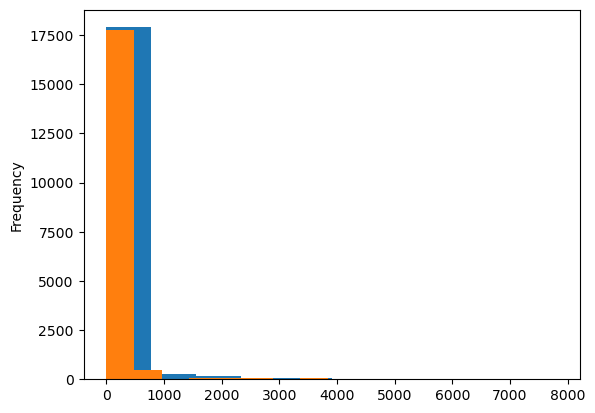

In [14]:
# Examine whether there is a difference is a difference between the two features
all_data_no_dupes["host_total_listings_count"].plot.hist()
all_data_no_dupes["host_listings_count"].plot.hist()

host_listings_count and host_total_listings_count appear to be the same, hots_total_listings_count will be removed to avoid redundancy.

In [15]:
# Drop one of the above variables in the chart
# Drop unneeded features
eda_subset = all_data_no_dupes.drop(
    columns = [
        "id", "scrape_id", "listing_url", "picture_url", "host_id", "host_url", 
        "host_name", "host_since", "host_location", "host_about", 
        "host_response_time", "host_response_rate", "host_acceptance_rate", 
        "host_is_superhost", "host_thumbnail_url", "host_picture_url", 
        "host_verifications", "host_has_profile_pic", "host_identity_verified",
        "last_scraped", "host_neighbourhood", "neighbourhood", "neighbourhood_cleansed",
        "amenities", "calendar_last_scraped", "first_review", 
        "last_review", "host_total_listings_count"
        ], 
    axis = 1
)

In [34]:
# Drop unnecessary symbols in price
eda_subset['price'] = eda_subset['price'].str.replace('$', '')
eda_subset['price'] = eda_subset['price'].str.replace(',', '')

# Convert price to a numeric feature
eda_subset['price'] = pd.to_numeric(eda_subset['price'])

In [35]:
# Descriptive Statistics of a Select Subset of Features
eda_subset.describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,18576.0,8.425732e+01,3.740649e+02,0.00000,1.000000,4.00000,20.000000,4.807000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,18627.0,3.276318e+01,9.228707e-02,32.51986,32.718332,32.75485,32.798349,3.312569e+01
longitude,18627.0,-1.171725e+02,7.343738e-02,-117.28258,-117.246039,-117.16462,-117.129225,-1.168966e+02
accommodates,18627.0,4.815483e+00,3.168323e+00,0.00000,2.000000,4.00000,6.000000,1.600000e+01
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,17089.0,1.985195e+00,1.289118e+00,1.00000,1.000000,2.00000,3.000000,3.400000e+01
beds,18411.0,2.666667e+00,2.271751e+00,1.00000,1.000000,2.00000,3.000000,8.500000e+01
price,18627.0,3.393529e+02,1.047108e+03,0.00000,112.000000,182.00000,330.000000,1.000000e+05
minimum_nights,18627.0,7.447093e+00,2.124885e+01,1.00000,1.000000,2.00000,4.000000,9.990000e+02


In [41]:
# Calculate Kurtosis and Skew
eda_subset_num_cols = eda_subset.select_dtypes(include=['number'])

kurtosis = eda_subset_num_cols.kurtosis()
skew = eda_subset_num_cols.skew()

dist_df = pd.DataFrame({
    'Feature' : skew.index,
    'Kurtosis': kurtosis.values,
    'Skew': skew.values
})

dist_df

,Feature,Kurtosis,Skew
0,host_listings_count,65.244082,7.552839
1,neighbourhood_group_cleansed,NaN,NaN
2,latitude,1.841342,0.229579
3,longitude,-0.136426,0.583827
4,accommodates,2.066253,1.381483
5,bathrooms,NaN,NaN
6,bedrooms,48.568693,3.595604
7,beds,161.210997,6.985253
8,price,4444.841099,50.351444
9,minimum_nights,626.306803,18.806223


## Missing Values Evaluation

In [17]:
# Examine Which Features Have Missing Values
eda_subset.isnull().sum().to_frame(name = "Missing_Value_Count").query("Missing_Value_Count > 0")

,Missing_Value_Count
description,138
neighborhood_overview,6735
host_listings_count,51
neighbourhood_group_cleansed,18627
bathrooms,18627
bathrooms_text,6
bedrooms,1538
beds,216
minimum_minimum_nights,2
maximum_minimum_nights,2


_License_ is missing 14,007 values from the 18,000 records. With such a high number of missing values, it would not be feasible or practical to impute or fill the missing values. Thus, the feature will be removed.

In [18]:
# Look at columns with missing values for every record
eda_subset.isnull().sum().to_frame(name = "Missing_Value_Count").query("Missing_Value_Count == 18627")

,Missing_Value_Count
neighbourhood_group_cleansed,18627
bathrooms,18627
calendar_updated,18627


In [19]:
# Drop columns that cannot be filled
eda_subset = eda_subset.drop(
    columns = ["neighbourhood_group_cleansed", "calendar_updated",
               "license"], 
        axis = 1
    )

3 columns, _neighbourhood_group_cleansed_, _bathrooms_, and _calendar_updated_, are missing values for every single row. While, _neighbourhood_group_cleansed_ and _calendar_updated_ may be dropped, as their information is not especially key to determining price, the number of _bathrooms_ is key.

_bathrooms_text_ is a text version of the the numerical bathrooms column. _Bathrooms_text_ can be used to fill the missing values for _bathrooms_.

### Filling _bathrooms_ Missing Values with Values from _bathrooms_text_

In [20]:
# Sample of text data used to fill numerical field
eda_subset[["bathrooms", "bathrooms_text"]].head(5)

,bathrooms,bathrooms_text
8853,NaN,2 baths
8839,NaN,1.5 baths
8838,NaN,1 bath
8819,NaN,1 private bath
8823,NaN,1 private bath


In [21]:
# Function to extract integers and floats from text
def bath_number(text):
    try:
        num_baths = re.search("[\d.]", text).group()
        # Returns integer or float
        return num_baths
    except:
        # If no value could be returned
        # Return a missing value placeholder
        return np.nan

# Apply function to bathroom_text column to fill bathrooms column
eda_subset["bathrooms"] = eda_subset["bathrooms_text"].apply(
    lambda x: bath_number(x)
)

In [22]:
# Assess bathroom values that could not be filled
eda_subset[eda_subset["bathrooms"].isnull()]["bathrooms_text"].value_counts()
# Text descriptions that do not contain numerical text will have to be filled manually

bathrooms_text
Private half-bath    69
Half-bath            16
Shared half-bath      6
Name: count, dtype: int64

In [23]:
# Fill missing bathroom values based on text values
eda_subset.loc[eda_subset["bathrooms_text"] == "Private half-bath", ["bathrooms"]] = 0.5
eda_subset.loc[eda_subset["bathrooms_text"] == "Half-bath", ["bathrooms"]] = 0.5
eda_subset.loc[eda_subset["bathrooms_text"] == "Shared half-bath", ["bathrooms"]] = 0.5

In [24]:
# After imputing the bathroom values with _bathroom_text_,
# Only 6 missing values for bathrooms remain
eda_subset["bathrooms"].isnull().sum()

6

In [25]:
# Fill remaining bathroom values with 1
eda_subset.loc[eda_subset["bathrooms"].isnull()]["bathrooms"] = 1

The feature bathrooms_text can now be dropped, as the feature bathroom now contains the same information, in numerical format.

In [26]:
# Drop bathrooms_text feature
eda_subset = eda_subset.drop(columns = ["bathrooms_text"], axis = 1)

## Zip Code and Median Income Feature Creation
From the given longitude and latitude coordinates, find the zip code of the rental property. Then, add a new column _median_income_ for the median income of the zip code, using census data.

In [27]:
search = SearchEngine()
search.by_coordinates(eda_subset["latitude"][0], eda_subset["longitude"][0], returns = 1)[0].zipcode

'92109'

In [28]:
# Set up a search engine
search = SearchEngine()

# Function to search for a zip code based on a coordinate pair
def get_zipcode(lat, lon):
    try:
        result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
        return result[0].zipcode
    except:
        return np.NaN

# Create a new column _zipcode_ and apply the get_zipcode function
## This takes a few minutes to complete
eda_subset['zipcode'] = eda_subset.apply(lambda x: get_zipcode(x["latitude"], x["longitude"]), axis=1)

In [29]:
# Confirm that there are no missing zipcode values
eda_subset["zipcode"].isnull().sum()

0

Zipcode 92133 was unfound in the census data; the closest zip code geographically is 92101. All records with a zipcode of 92133 will be updated to 92101.

In [30]:
# Replacing zipcode 92133 with 92101
eda_subset.loc[eda_subset["zipcode"] == "92133", "zipcode"] = "92101"

### Median Income Data Information
Import in median income data and join the tables together based on zipcode.

In [31]:
# Read in median income information
income_df = pd.read_csv("../Data/SanDiego5Y2021_IncomeData.csv")

In [32]:
# Extract only the necessary columns
income_df_subset = income_df.filter(
    regex = "!!Households!!Estimate",
    axis = 1
)

# Rename Columns to just contain 5-digit zipcodes
income_df_subset.columns = [x[6:11] for x in income_df_subset.columns]

# Insert Label (Grouping) Col
income_df_subset.insert(0, "Labels", income_df["Label (Grouping)"])
# Set Label column as index
income_df_subset.set_index("Labels", inplace = True)

# Transpose Table
income_df_subset_T = income_df_subset.T
# Move zipcodes out of index - make a column of zipcodes
income_df_subset_T.reset_index(inplace = True)
# Rename index column as "zipcode"
income_df_subset_T.columns.values[0] = "zipcode"
# Keep just median income column
median_income_df = income_df_subset_T[["zipcode", "Median income (dollars)"]]

median_income_df.head(3)

Labels,zipcode,Median income (dollars)
0,91902,"112,331"
1,91910,"77,005"
2,91911,"70,873"


In [33]:
# Add to eda_subset _median_income_ column based on existing zipcode
eda_income_df = pd.merge(eda_subset, median_income_df, how = "inner", on = "zipcode")

# Rename median income column
eda_income_df.rename(
    columns = {"Median income (dollars)" : "median_income_dollars"}, 
    inplace=True
)


# Change median income datatype from string to float
eda_income_df["median_income_dollars"] = eda_income_df[
    "median_income_dollars"].str.replace(',', '').astype(float)

## Altering Datatypes for EDA Purposes

In [34]:
# Convert bathrooms to a numerical value
eda_income_df["bathrooms"] = pd.to_numeric(eda_income_df["bathrooms"])

# Change zip code to a numeric feature for plottting purposes
eda_income_df['zipcode'] = pd.to_numeric(eda_income_df['zipcode'])

## Feature Distribution
Examine the distribution of each feature

### Target Feature Distribution

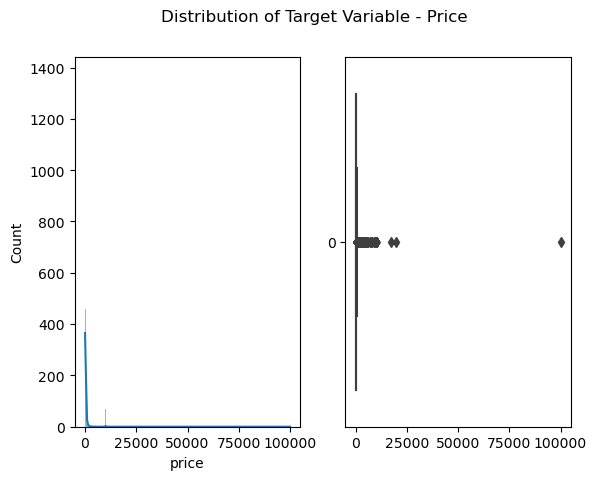

In [35]:
# Plot the distribution of the target variable
plt.subplot(1, 2, 1)
sns.histplot(eda_income_df["price"], kde = True)

plt.subplot(1, 2, 2)
sns.boxplot(eda_income_df["price"], orient = "h")

plt.suptitle("Distribution of Target Variable - Price")
plt.show()

There is an extreme outlier at 100,000. Let's replot the data without it to get a better feel for the distribution

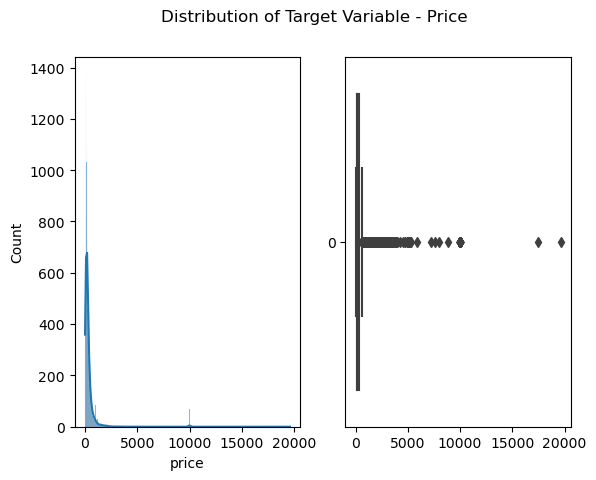

In [36]:
# Remove the outlier
price_no_outlier = eda_income_df[eda_income_df["price"] < 80000]["price"]

# Re-Plot the distribution of the target variable
plt.subplot(1, 2, 1)
sns.histplot(price_no_outlier, kde = True)

plt.subplot(1, 2, 2)
sns.boxplot(price_no_outlier, orient = "h")

plt.suptitle("Distribution of Target Variable - Price")
plt.show()

The price variable is right-skewed with many high prices acting as outliers. Various transformation will be applied to attempt to normalize the distribution.

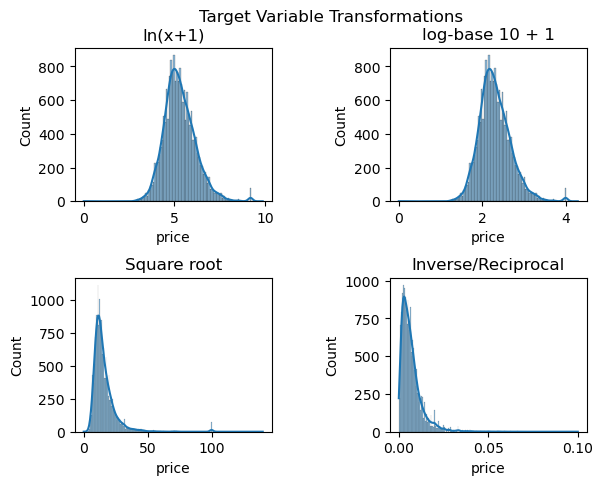

In [37]:
# ln(x+1) Transformation
plt.subplot(2,2,1)
sns.histplot(np.log(price_no_outlier + 1), kde = True)
plt.title("ln(x+1)")

# log-base 10 Transformation
plt.subplot(2,2,2)
sns.histplot(np.log10(price_no_outlier + 1), kde = True)
plt.title("log-base 10 + 1")

# Square Root Transformation
plt.subplot(2,2,3)
sns.histplot(np.sqrt(price_no_outlier), kde = True)
plt.title("Square root")

# Inverse/Reciprocal
plt.subplot(2,2,4)
sns.histplot(np.reciprocal(price_no_outlier), kde = True)
plt.title("Inverse/Reciprocal")

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1,
                    right = 0.9,
                    top = 0.9,
                    wspace = 0.6,
                    hspace = 0.5)


plt.suptitle("Target Variable Transformations")
plt.show()

In [38]:
# Skewness of price
print("Skewnewss of Price: %f" % eda_income_df["price"].skew())
print("Kurtosis of Price: %f" % eda_income_df["price"].kurt())

Skewnewss of Price: 50.351444
Kurtosis of Price: 4444.841099


#### Price Descriptive Statistics

In [39]:
eda_income_df["price"].describe()

count     18627.000000
mean        339.352929
std        1047.108431
min           0.000000
25%         112.000000
50%         182.000000
75%         330.000000
max      100000.000000
Name: price, dtype: float64

### Distribution of Every Feature

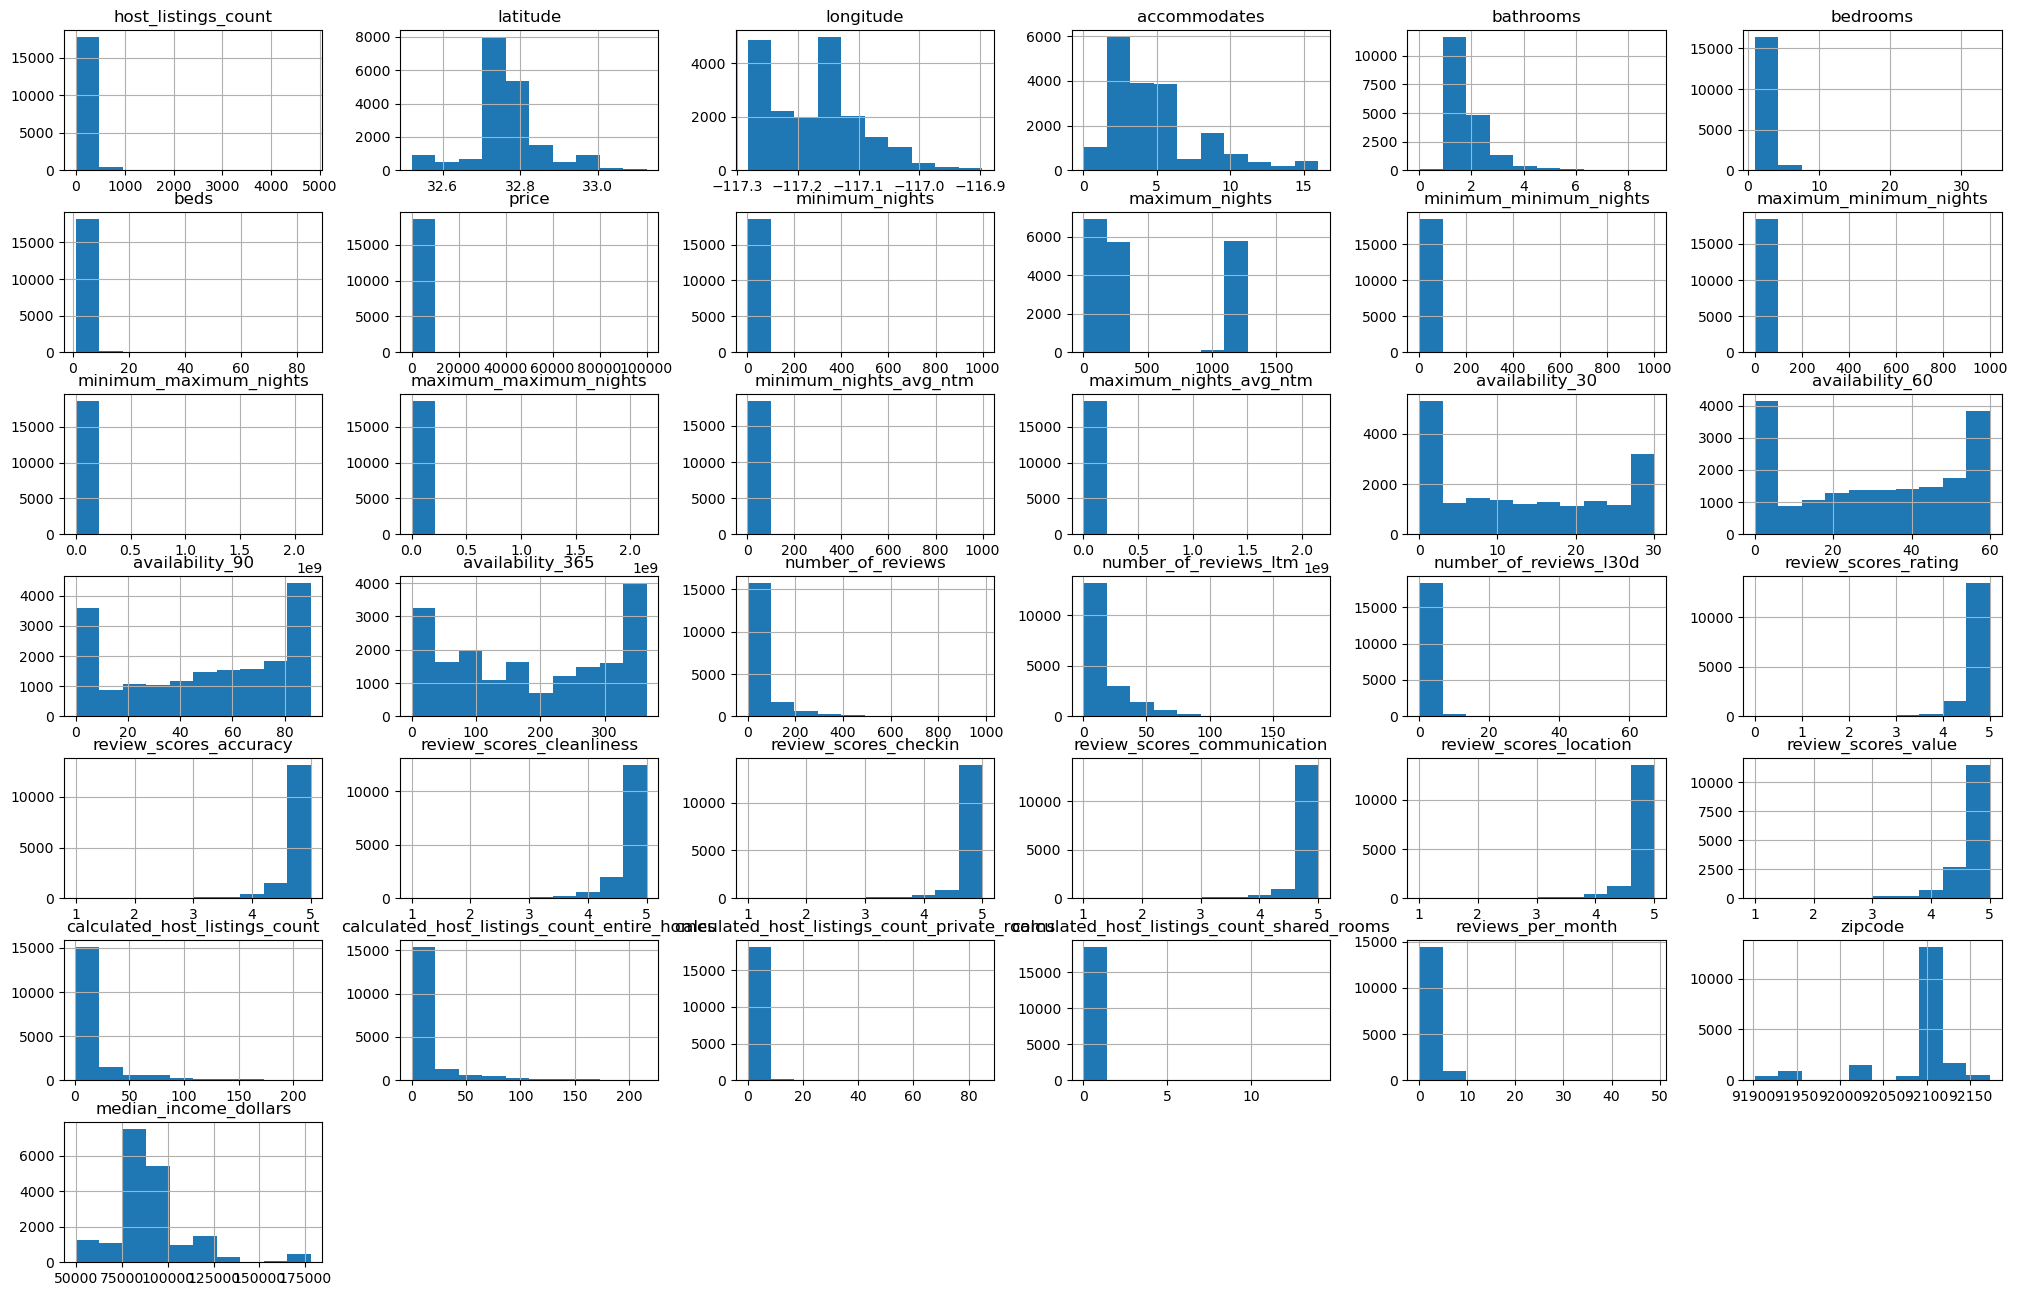

In [40]:
# Set figure dimensions
fig = plt.figure(figsize=(25, 16))
axes = fig.gca()

# Plot a histogram for each feature
# Drop arbitrary id column prior to plotting
eda_income_df.hist(ax = axes)

plt.show()

## Bivariate EDA

### Relationship of Numerical Predictors to Outcome Variable (Price)

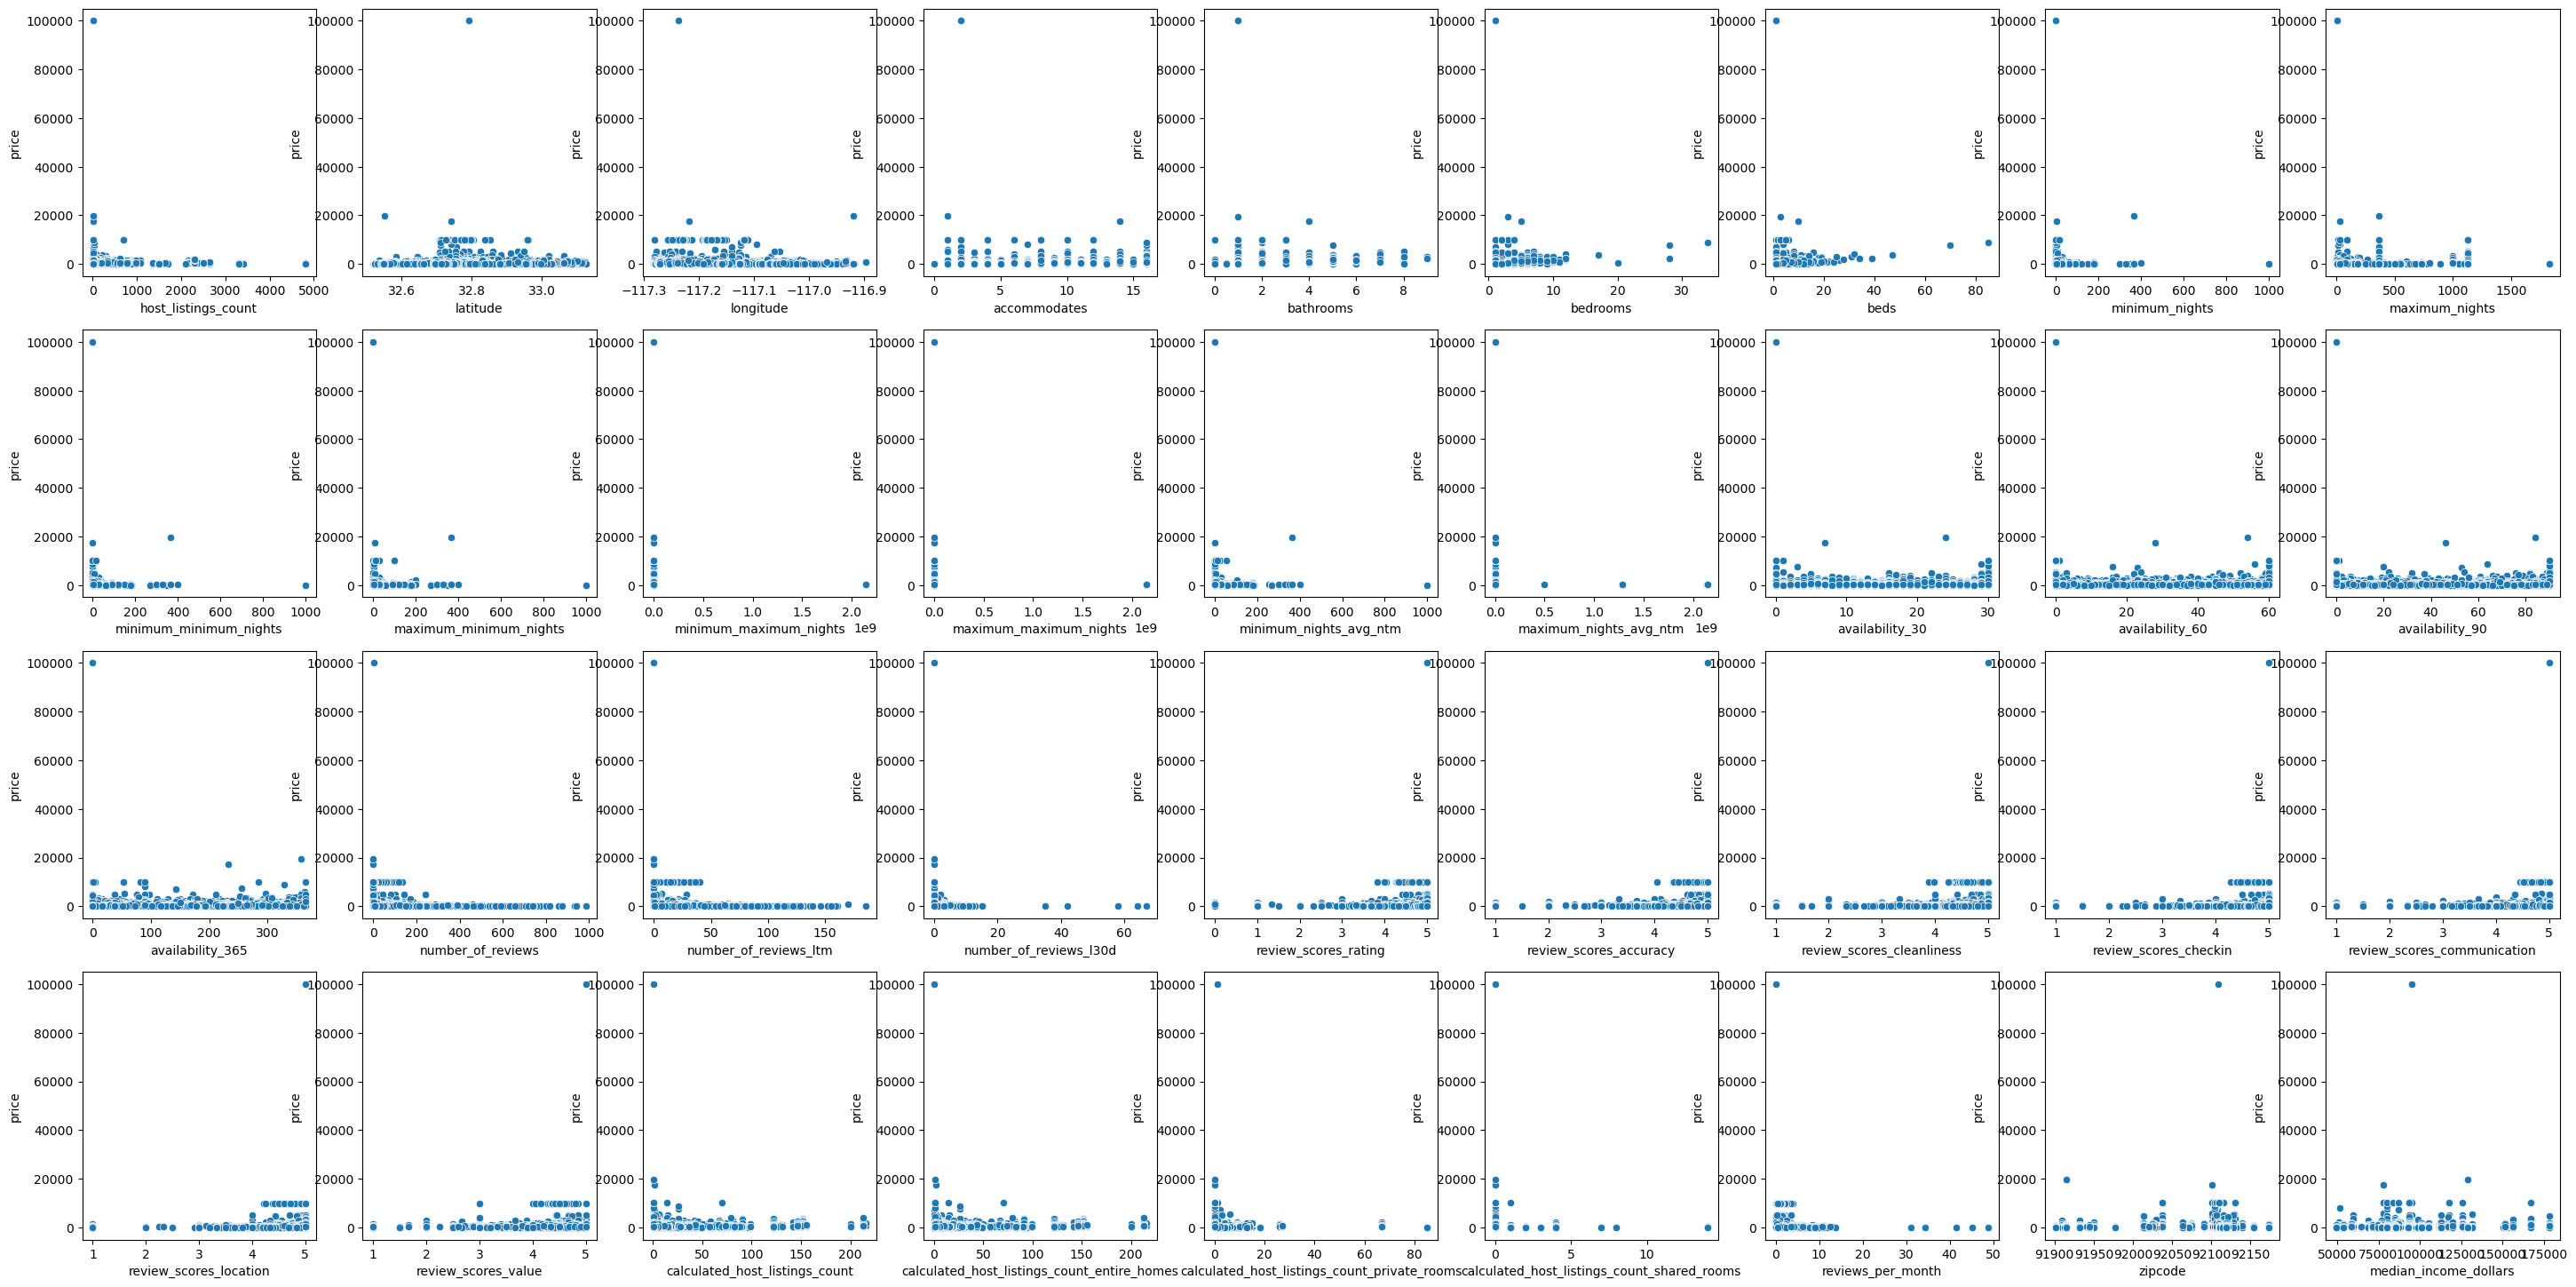

In [41]:
# Subset numerical columns
num_feat_df = eda_income_df.select_dtypes(["int", "float"])

# Set up enough boxes for 38 features
fig, axes = plt.subplots(nrows = 4, ncols = 9)
fig.set_figheight(18)
fig.set_figwidth(36)

# Iterate over numerical features to plot against price
i = 0
j = 0
for col in num_feat_df.columns.values.tolist():
    # Avoid plotting price against itself
    if col != "price":
        sns.scatterplot(
            x = num_feat_df[col], 
            y = num_feat_df["price"], 
            ax = axes[i,j]
            )
        # fill the subplots row by row
        if j < 8:
            j += 1
        # if j = 9, move to the next row
        else:
            i += 1
            j =0
    else: pass

plt.show();

One record appears to be an outlier, with a price of approximately $100,000. The same analysis will be performed in the absence of the outlier point, in an attempt to gain clearer insights on the relationships between predictors and the outcome feature.

In [42]:
num_feat_df[num_feat_df["price"] > 80000]

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,...,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,zipcode,median_income_dollars
2637,1.0,32.7919,-117.23807,2,1.0,1.0,1.0,100000.0,1,3,...,5.0,5.0,5.0,1,0,1,0,0.04,92109,95170.0


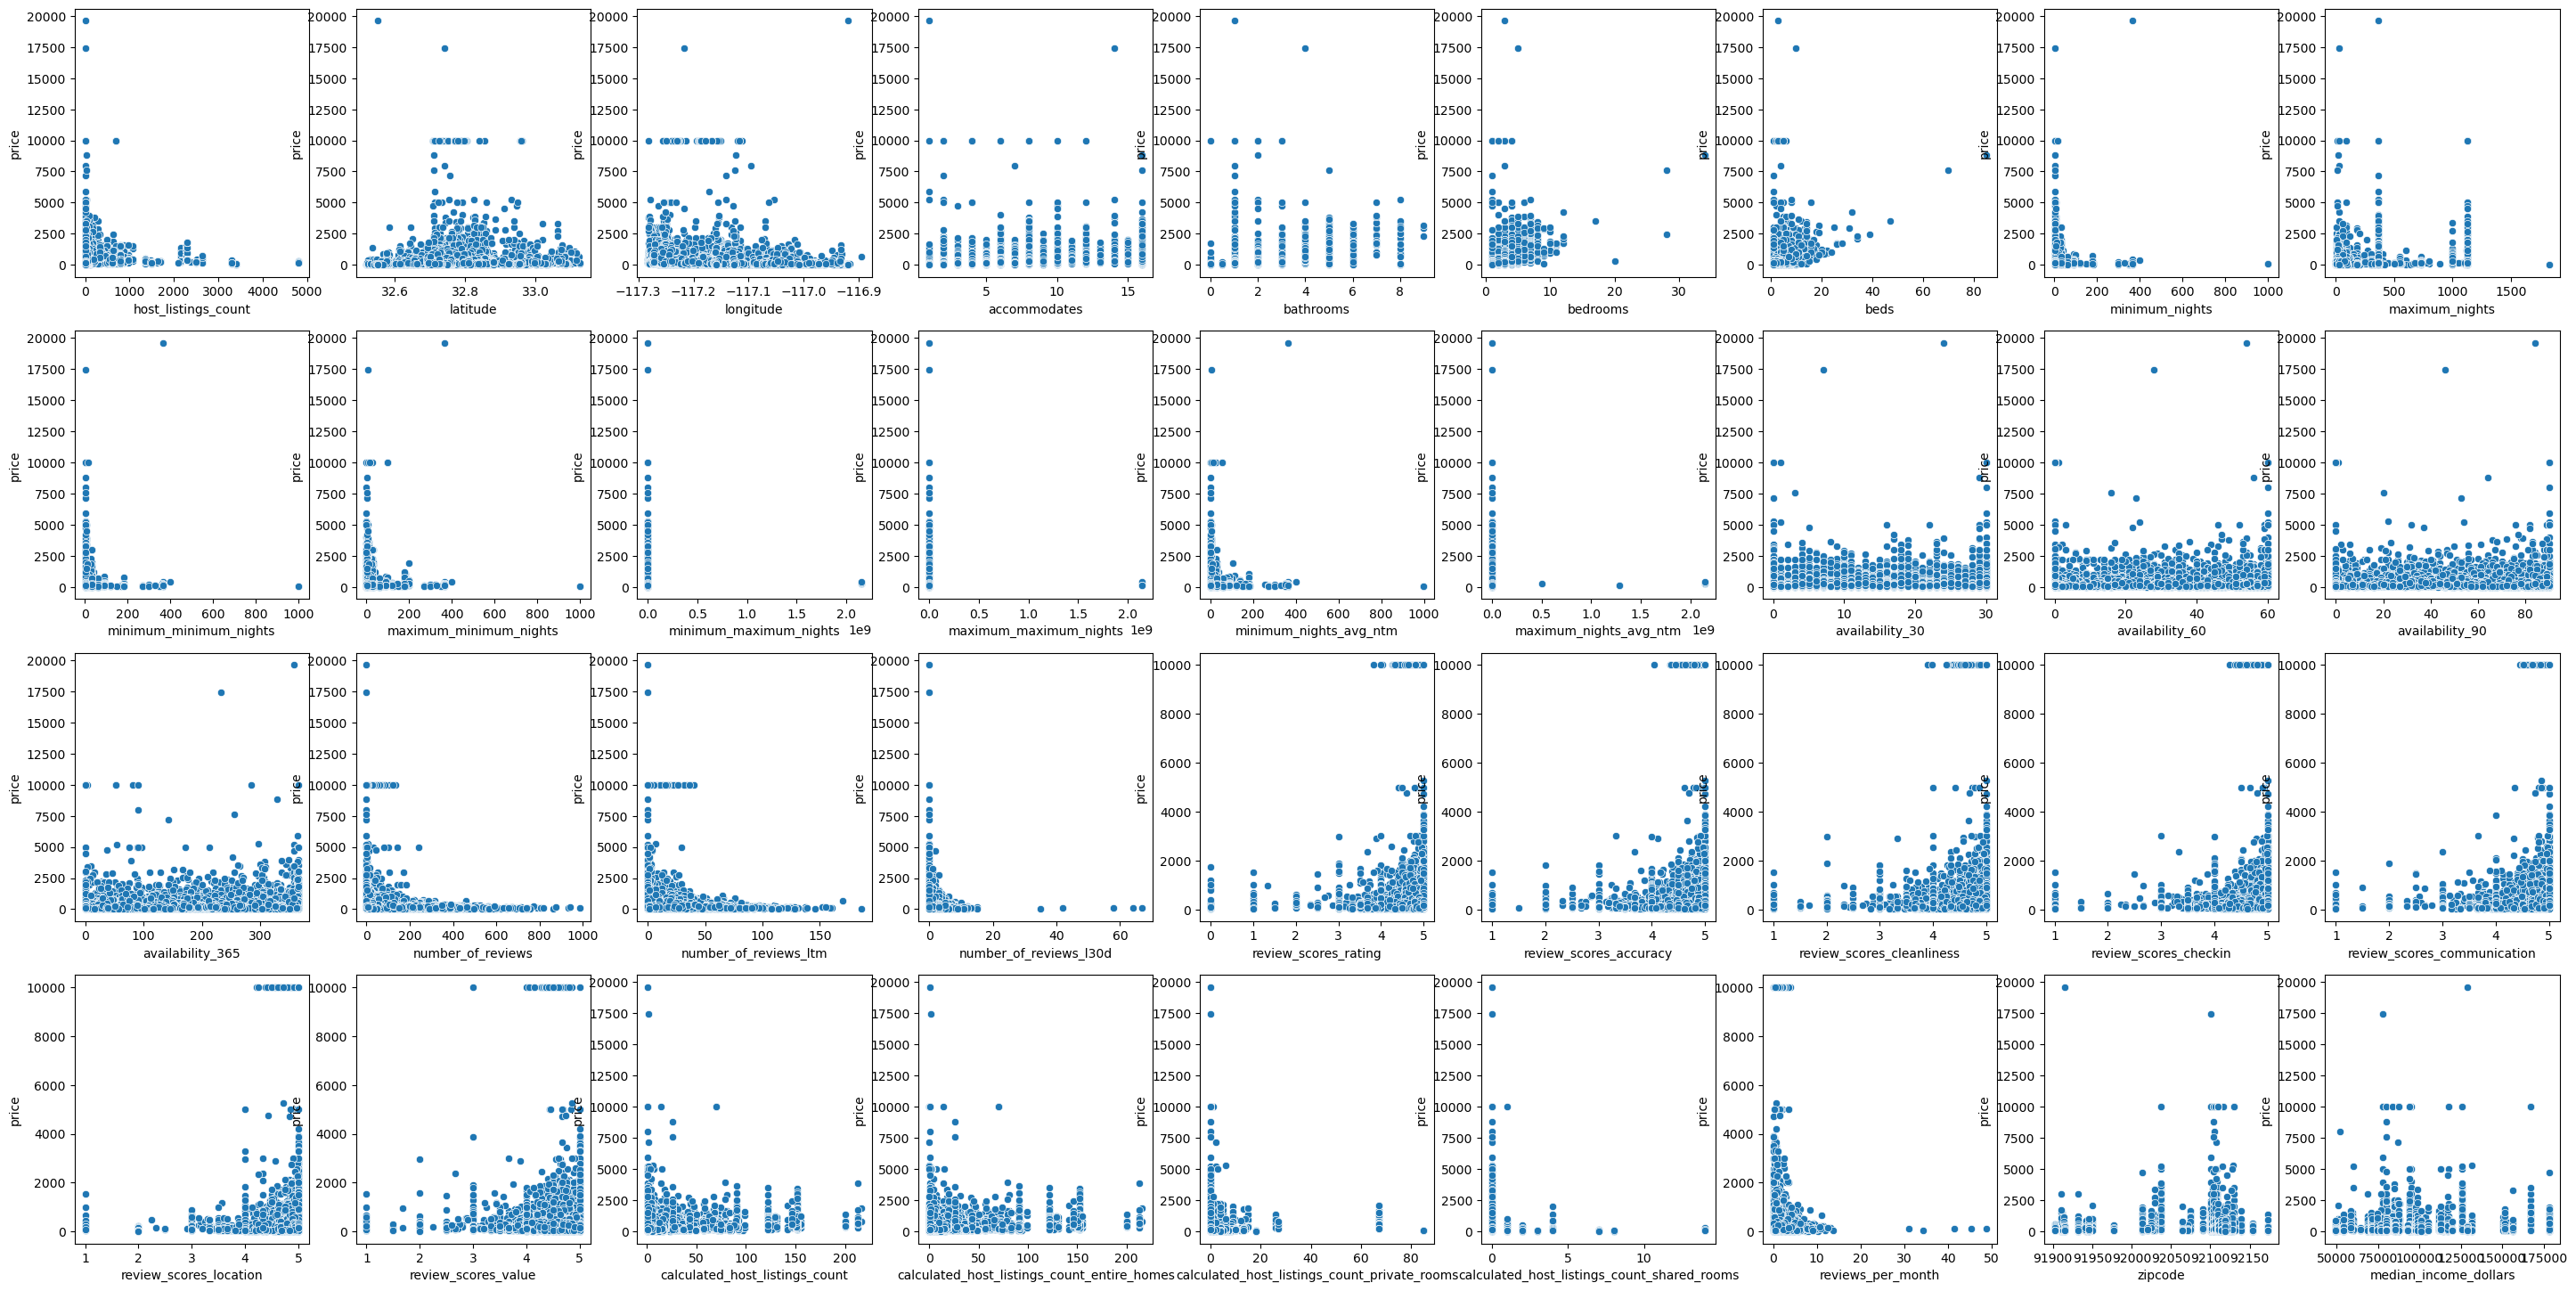

In [43]:
# Drop outlier where price = $100,000
num_feat_df.drop(index = 2637, inplace = True)
# Remove data where price == $0
num_feat_df = num_feat_df[num_feat_df["price"] != 0]

# Re-plot bivariate scatterplots without the outlier record
# Set up enough boxes for 38 features
fig, axes = plt.subplots(nrows = 4, ncols = 9)
fig.set_figheight(18)
fig.set_figwidth(36)

# Iterate over numerical features to plot against price
i = 0
j = 0
for col in num_feat_df.columns.values.tolist():
    # Avoid plotting price against itself
    if col != "price":
        sns.scatterplot(
            x = num_feat_df[col], 
            y = num_feat_df["price"], 
            ax = axes[i,j]
            )
        # fill the subplots row by row
        if j < 8:
            j += 1
        # if j = 9, move to the next row
        else:
            i += 1
            j =0
    else: pass

plt.show();

Looking at review-related features, the more 5- or 4-start reviews a place has for any given review-based feature, the more likely it is that the listing has a higher price. More interestingly, the less reviews a listing gets per month, the more expensive it is, suggesting that customers that pay more tend to write less reviews per month.

### Bedrooms vs Bathrooms
Determine if the size of the listing (determined by the number of bedrooms and bathrooms available) have a relationship with the overall price.

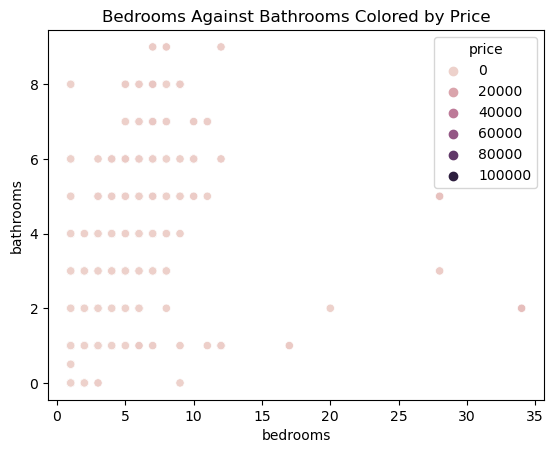

In [44]:
# Plot the number of bedrooms against the number of bathrooms
# Colored by price
sns.scatterplot(x = eda_income_df["bedrooms"], 
                y = eda_income_df["bathrooms"],
                hue = eda_income_df["price"]
                )

plt.title("Bedrooms Against Bathrooms Colored by Price")
plt.show()

While the above analysis did not reveal any relationship between the two features and price, it did reveal that there are outlier records, such as those with nearly 35 bedrooms but only 2 bathrooms. A manual assessment of these listings revealed that they are not outliers but rather communal living spaces, where a single or few bathrooms are shared amongts multiple bedrooms.

## Feature Correlation
Evaluate the correlation amongst variables via Pearson's correlation coefficient and a heatmap.

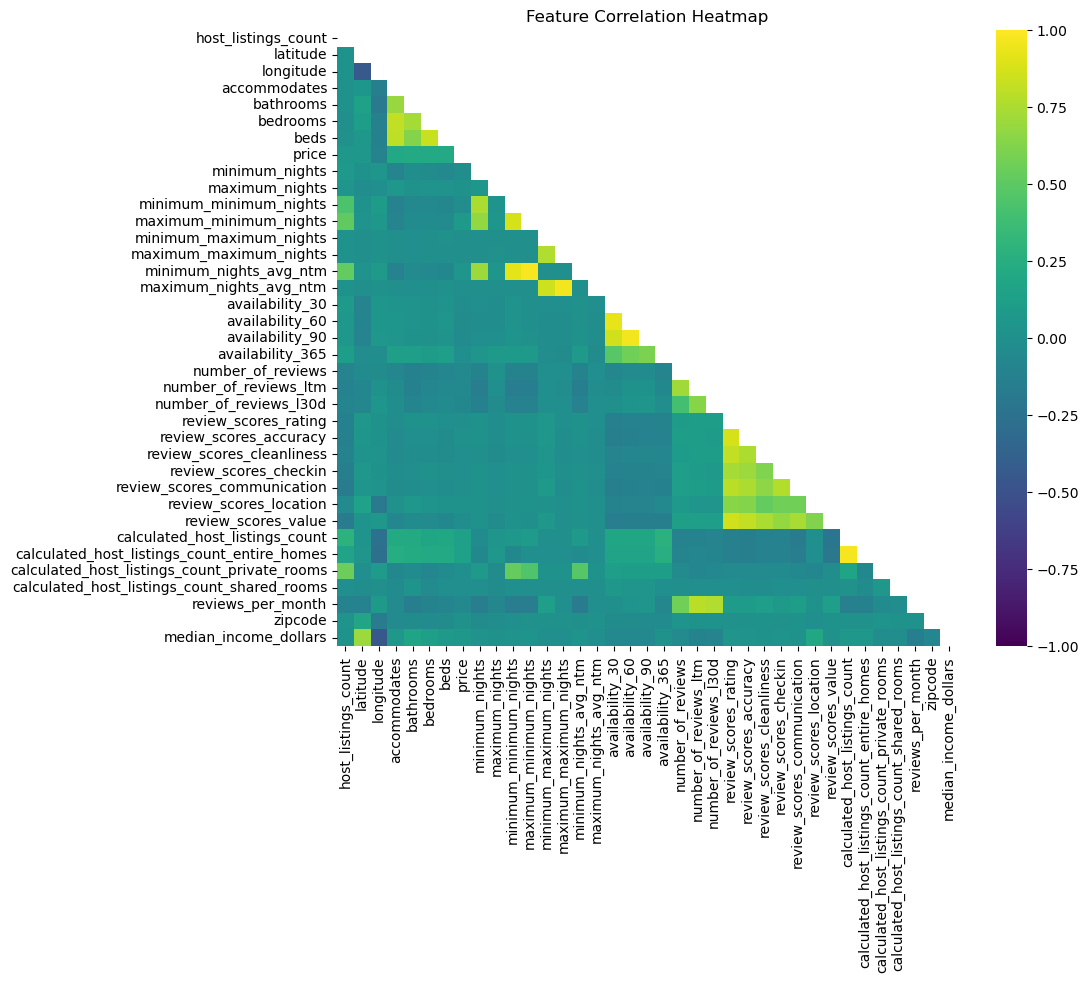

In [45]:
# Calculate the correlation coefficient between every feature pair
corr_matrix = eda_income_df.select_dtypes(["int", "float"]).corr()

# Create a mask 
matrix_mask = np.triu(np.ones_like(corr_matrix))

# Convert the correlation matrix into a heatmap
# Set values to range from -1 to 1
plt.figure(figsize=(10, 8))
corr_heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1,
                           cmap = "viridis",
                           mask = matrix_mask)

corr_heatmap.set_title("Feature Correlation Heatmap")
plt.show();

In [46]:
# Function to observe highly correlated features
def high_correlation(df, threshold = 0.75):
	# Correlation Matrix for Numerical Features
	corr_matrix = df.select_dtypes(["int", "float"]).corr()

	# Get features with a correlation coefficient above the set threshold
	# Use the absolute value to capture both positive and negative coefficients
	corr_features = np.where(np.abs(corr_matrix) > threshold)

	# Exclude self-correlation (i.e. feat. a is correlated with feat. a)
	corr_features = [
		(corr_matrix.iloc[x,y], x, y) for x, y in zip(*corr_features) if x != y and x < y]
	
	# Sort Values
	corr_list = sorted(corr_features, key = lambda x: -abs(x[0]))

	if corr_list == []:
		print("There are no highly correlated features with correlation above", threshold)
	else:
		for z, x, y in corr_list:
			cols = df.select_dtypes(["int", "float"]).columns
			print ("%s and %s = %.3f" % (corr_matrix.index[x], corr_matrix.columns[y], z))

In [47]:
high_correlation(eda_income_df)

maximum_minimum_nights and minimum_nights_avg_ntm = 0.980
calculated_host_listings_count and calculated_host_listings_count_entire_homes = 0.972
availability_60 and availability_90 = 0.968
maximum_maximum_nights and maximum_nights_avg_ntm = 0.963
availability_30 and availability_60 = 0.926
minimum_minimum_nights and minimum_nights_avg_ntm = 0.917
review_scores_rating and review_scores_accuracy = 0.871
minimum_minimum_nights and maximum_minimum_nights = 0.870
review_scores_rating and review_scores_value = 0.857
availability_30 and availability_90 = 0.856
minimum_maximum_nights and maximum_nights_avg_ntm = 0.847
bedrooms and beds = 0.830
review_scores_accuracy and review_scores_value = 0.816
review_scores_rating and review_scores_cleanliness = 0.815
accommodates and bedrooms = 0.812
accommodates and beds = 0.802
review_scores_rating and review_scores_communication = 0.796
number_of_reviews_ltm and reviews_per_month = 0.796
review_scores_checkin and review_scores_communication = 0.767
min

24 feature pairs had correlations above 0.75 - we removed one feature from each of these pairs. Some showed up multiple times (high correlation with multiple features), so 24 drops may not show up.

In [48]:
# Remove highly correlated features
eda_income_df = eda_income_df.drop(columns = [
    'minimum_nights_avg_ntm', 'calculated_host_listings_count_entire_homes',
    'availability_90', 'maximum_nights_avg_ntm', 'availability_60', 'minimum_nights_avg_ntm',
    'review_scores_accuracy', 'maximum_minimum_nights', 'review_scores_value', 'beds',
    'review_scores_cleanliness', 'accommodates', 'review_scores_communication',
    'number_of_reviews_ltm', 'minimum_maximum_nights', 'number_of_reviews_l30d']
    )

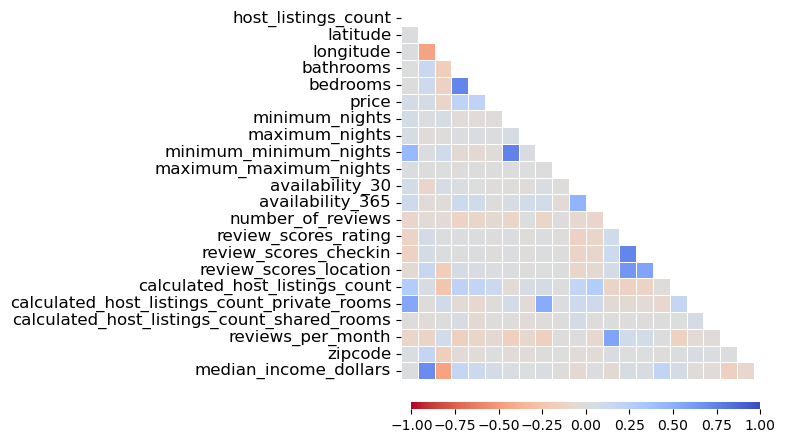

In [50]:
# Correlation matrix after feature removal
# Calculate the correlation coefficient between every feature pair
corr_matrix = eda_income_df.select_dtypes(["int", "float"]).corr()

# Create a mask 
matrix_mask = np.triu(np.ones_like(corr_matrix))

# Reverse cmap so red is negative
reversed_cmap = plt.cm.get_cmap('coolwarm').reversed()

# Convert the correlation matrix into a heatmap
# Set values to range from -1 to 1
plt.figure(figsize=(9, 6))
corr_heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, center = 0,
                           cmap = reversed_cmap,
                           square = True,
                           linewidths= 0.5,
                           mask = matrix_mask,
                           cbar_kws={"orientation" : "horizontal", "pad": 0.05, "aspect": 50, "shrink": 0.5})


corr_heatmap.set_xticklabels([])
corr_heatmap.set_xticks([])

plt.yticks(fontsize = 12)
plt.show();

## Outlier Detection

In [173]:
# Z-score for presence of outliers

# Re-select numerical features
num_feat_df = eda_income_df.select_dtypes(["int", "float"])
# Calculate Z-scores
z_score_df = num_feat_df.apply(zscore)

# Define the threshold for identifying outliers (e.g., Z-score > 3 or Z-score < -3)
threshold = 3

# Filter with any Z-score exceeding the threshold
outliers_df = z_score_df[(z_score_df.abs() > threshold).any(axis=1)]

# Print the DataFrame with potential outliers
print(outliers_df.shape)

(2613, 22)


Based on a threshold of three standard deviations, there are an estimated 2,613 outlier data points in the data.

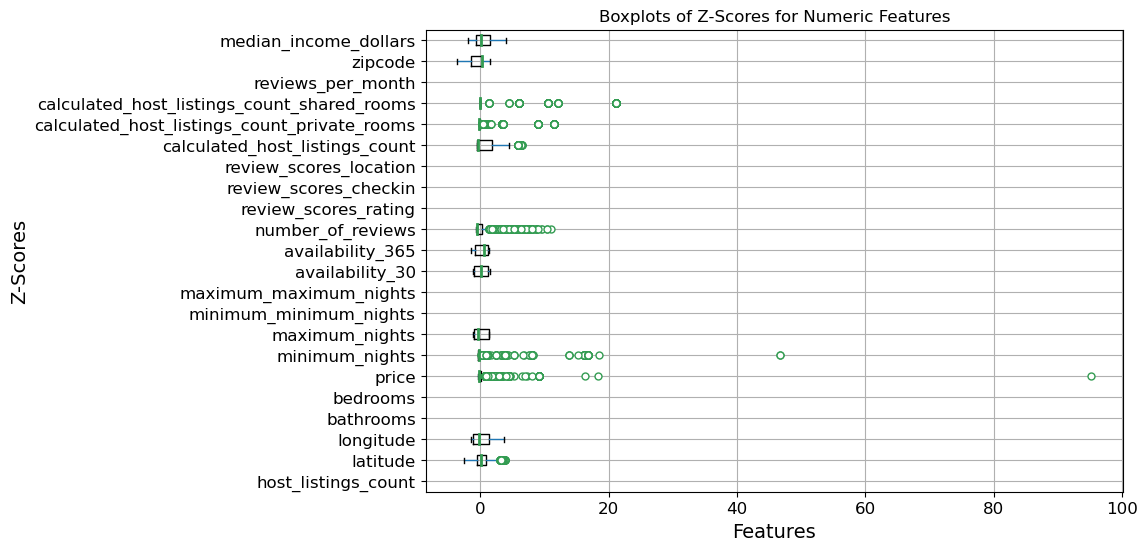

In [242]:
# Box plot of outliers with z score
plt.figure(figsize=(9,6))

# Custom color
paper_green = '#339c52'

# Box plot options
boxprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='white', markeredgecolor=paper_green)
medianprops = dict(linestyle='-', linewidth=2, color=paper_green)

outliers_df.boxplot(vert=False,boxprops=boxprops, flierprops=flierprops, medianprops=medianprops)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Z-Scores', fontsize = 14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Boxplots of Z-Scores for Numeric Features")
plt.show()

## Feature Variance
Assess the variance of all features and determine if features with a near-zero variance should be kept or removed. Latitude and longitude can be removed, especially since we're using a categorical zipcode as a substitute. However, we'll leave them in until we're done with EDA in case we want them for mapping purposes.

In [52]:
var_df = eda_income_df.select_dtypes(include=np.number).var()
var_df.sort_values().head(25)

longitude                                       5.393049e-03
latitude                                        8.516903e-03
review_scores_location                          1.045569e-01
review_scores_checkin                           1.209852e-01
review_scores_rating                            1.861285e-01
calculated_host_listings_count_shared_rooms     4.321014e-01
bathrooms                                       8.085493e-01
bedrooms                                        1.661824e+00
reviews_per_month                               3.529879e+00
calculated_host_listings_count_private_rooms    5.265708e+01
availability_30                                 1.182881e+02
minimum_nights                                  4.515135e+02
minimum_minimum_nights                          7.184435e+02
calculated_host_listings_count                  9.508153e+02
zipcode                                         2.767928e+03
number_of_reviews                               7.273063e+03
availability_365        

Latitude and longitude display have variances near zero, a property that would usually lead to the features being removed. However, for further geospatial analysis and extraction of zip code information, the features will be kept for the moment.

## Maps
### Plot zip codes and boundaries colored by median income

Source for San Diego geojson file - https://sdgis-sandag.opendata.arcgis.com/datasets/SANDAG::zip-code/explore?location=32.916477%2C-114.604036%2C8.00

In [53]:
# Change median income column to a float data type for chloropleth
median_income_df["Median income (dollars)"] = median_income_df[
    "Median income (dollars)"].str.replace(',', '').astype(float)

# Read in geojson file
SD_zip_shapes = geopandas.read_file("../Data/SDZips.geojson")

# Join the zipcodes we need
median_income_df["zipcode"] = pd.to_numeric(median_income_df["zipcode"])
SD_gdf = median_income_df.merge(
    SD_zip_shapes, left_on = "zipcode", 
    right_on = "ZIP", how = "left"
)

# Had a few duplicate zipcodes from the geojson, we'll drop them
SD_gdf = SD_gdf.drop_duplicates(subset = ["zipcode"])

# Finish geodataframe
SD_gdf_income = geopandas.GeoDataFrame(
    SD_gdf["Median income (dollars)"], 
    geometry=SD_gdf.geometry
    )

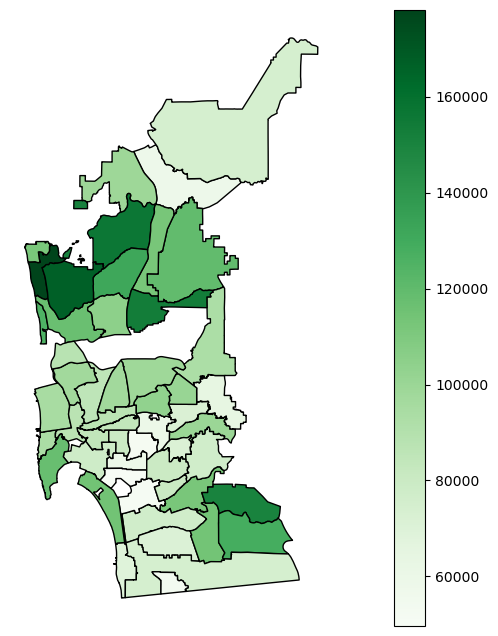

In [224]:
SD_gdf_income.plot(
    column = "Median income (dollars)", 
    cmap = "Greens", edgecolor = "k", 
    legend = True, figsize = (16,8)
)

plt.axis("off");

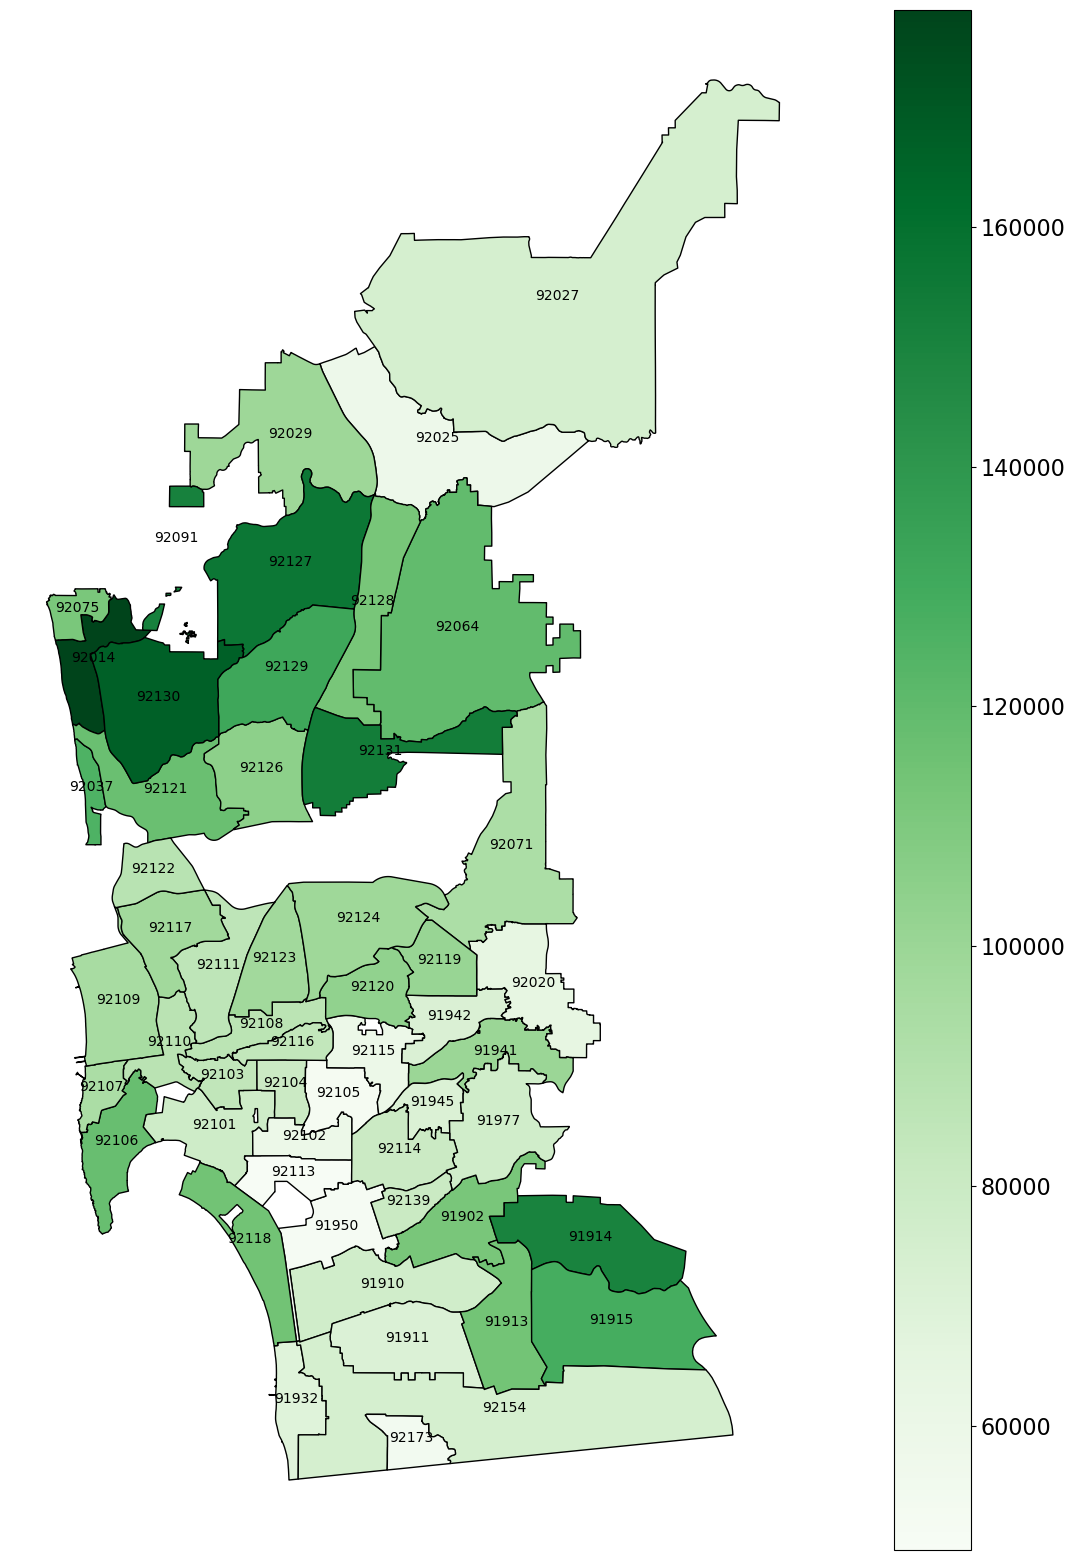

In [253]:
# Plot our map
ax = SD_gdf_income.plot(
    column = "Median income (dollars)", 
    cmap = "Greens", edgecolor = "k", 
    legend = False, figsize = (20,20)
)

# Manaually create legend so we can adjust its size
legend = plt.colorbar(ax.get_children()[0], ax=ax)
legend.ax.tick_params(labelsize = 16)

# Label areas with zipcode
SD_gdf.apply(lambda x: ax.annotate(
    text = x["zipcode"], 
    xy = x.geometry.centroid.coords[0], 
    ha = "center"), axis=1)

plt.axis("off");

### Average Rent by Zip Code

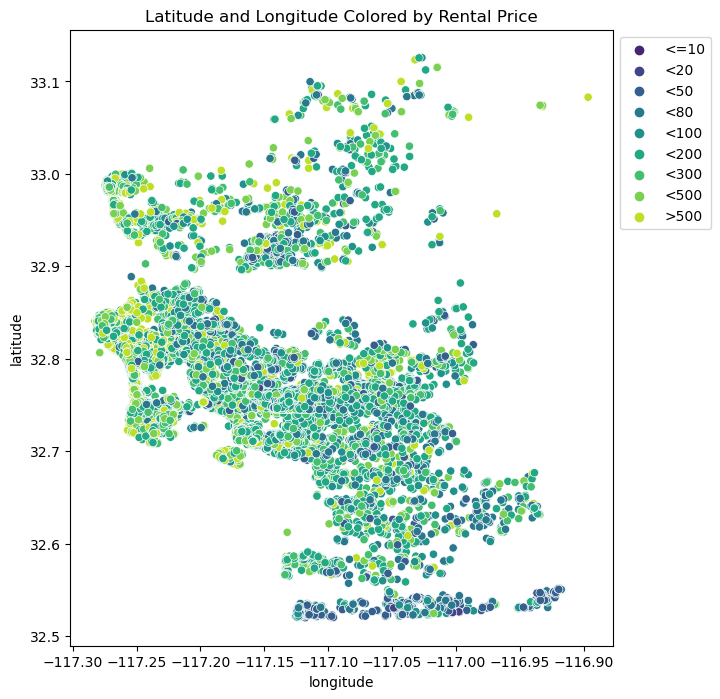

In [55]:
# Custom Rental Bins Plot
# Divide prices into bins
price_custom_bins = pd.cut(
    eda_income_df["price"], 
    [0, 10, 20, 50, 80, 100, 200, 300, 500, 1000], 
    labels = ["<=10", "<20", "<50", "<80", "<100",
              "<200", "<300", "<500", ">500"]
    )

plt.figure(figsize = (7, 8))
# Plot latitude and longitude and color by custom price bin
sns.scatterplot(
    x = eda_income_df["longitude"], y = eda_income_df["latitude"], 
    hue = price_custom_bins, palette = "viridis")

plt.title("Latitude and Longitude Colored by Rental Price")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [56]:
# Create an average rent-zipcode dataframe
rent_zip = eda_income_df.groupby(by = 'zipcode', as_index = False)['price'].mean()
rent_zip = rent_zip.merge(SD_gdf, left_on = 'zipcode', right_on = 'zipcode')
rent_zip_gdf = geopandas.GeoDataFrame(rent_zip['price'], geometry = rent_zip['geometry'])

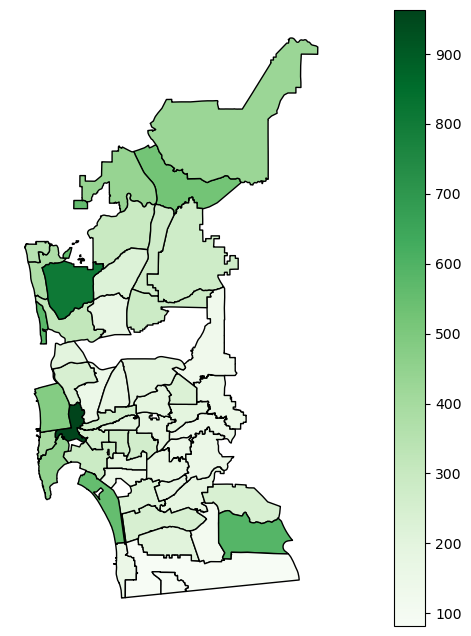

In [226]:
# Plot average rent by zip code
rent_map = rent_zip_gdf.plot(
    column = "price", cmap = "Greens", 
    edgecolor = "k", legend = True, 
    figsize=(16,8)
)


plt.axis('off');

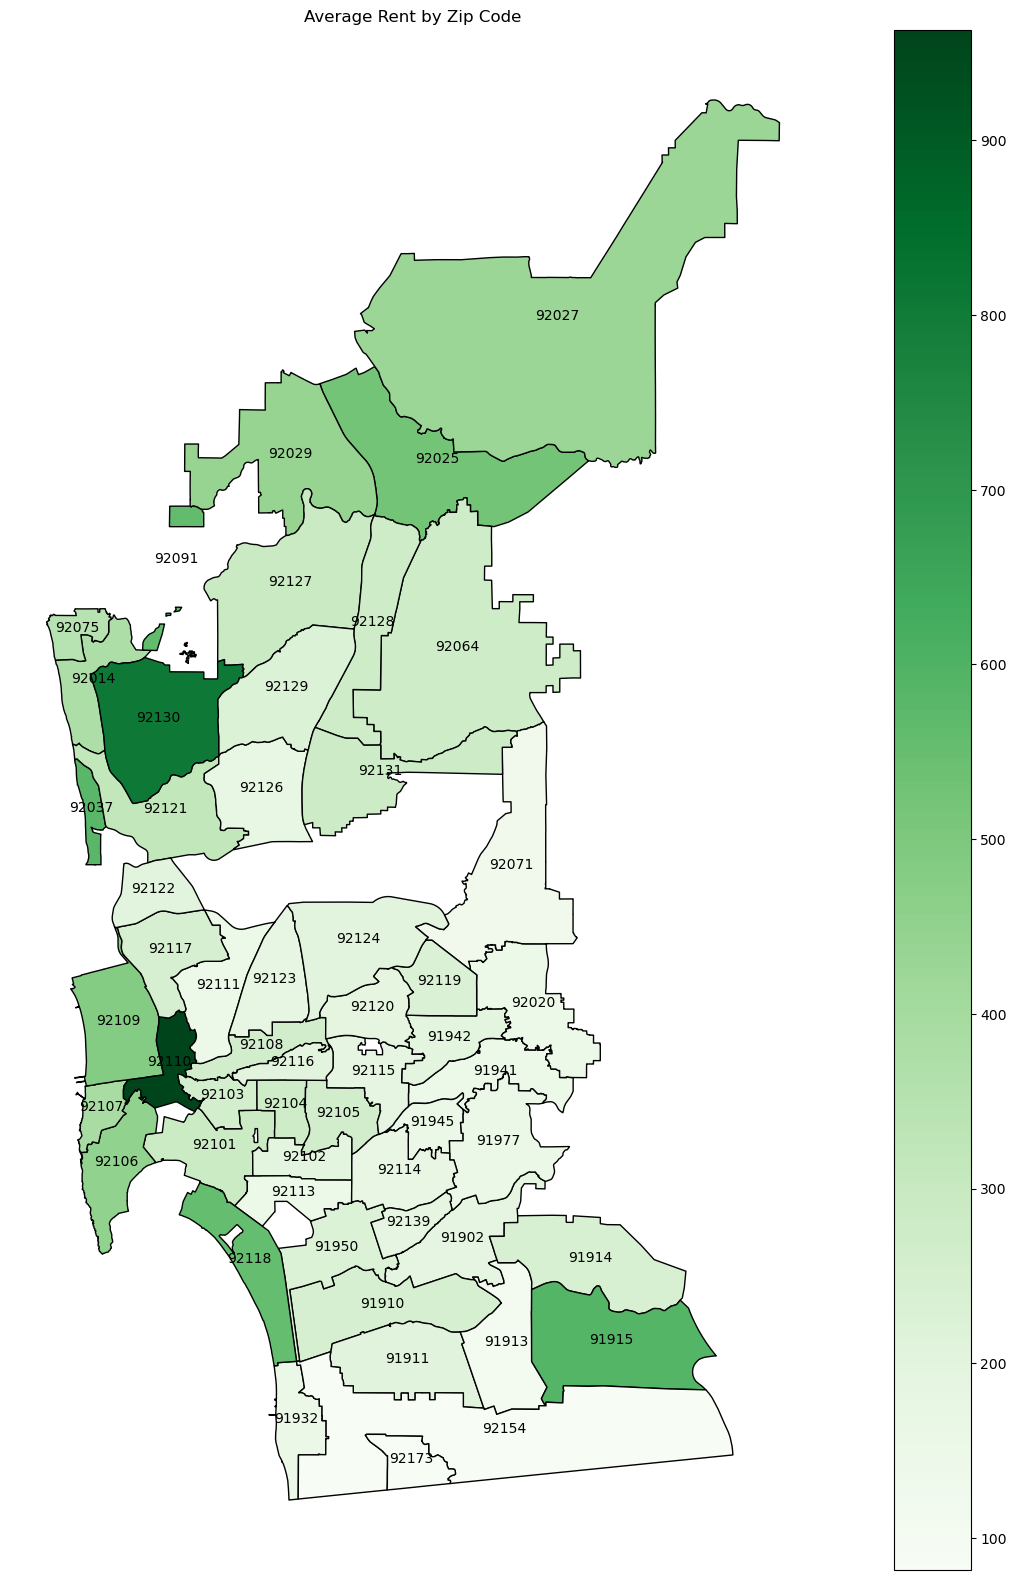

In [252]:
# Plot average rent by zip code
rent_map = rent_zip_gdf.plot(
    column = "price", cmap = "Greens", 
    edgecolor = "k", legend = True, 
    figsize=(20,20)
)

# Label areas with zipcode
rent_zip.apply(lambda x: rent_map.annotate(
    text = x["zipcode"], 
    xy = x.geometry.centroid.coords[0], 
    ha = "center"), axis=1)

plt.title("Average Rent by Zip Code")
plt.axis('off');

## Property Type Analysis

### Create new binary column for Property Type 

- New binary column (property_type_binary) - Values are either room or house
- New binary column private (0 - not a private room (i.e. shared room), 1 - private)

In [58]:
#Create the new "property_type_binary" column
eda_income_df["property_type_binary"] = eda_income_df["property_type"].apply(
    lambda x: "room" if "room" in x.lower() else "house")

# Create the new "private" column
eda_income_df["private"] = eda_income_df["property_type"].apply(
    lambda x: 1 if "private" in x.lower() or "entire" in x.lower() else 0)

# Optional: You can convert the "private" column to integer type if needed
eda_income_df["private"] = eda_income_df["private"].astype(int)

# Print the updated DataFrame
eda_income_df[["property_type", "property_type_binary", "private"]]

,property_type,property_type_binary,private
0,Entire home,house,1
1,Private room in condo,room,1
2,Entire home,house,1
3,Entire home,house,1
4,Camper/RV,house,0
...,...,...,...
18622,Entire rental unit,house,1
18623,Entire home,house,1
18624,Private room in home,room,1
18625,Entire guesthouse,house,1


### Some Counting Stats
Private vs. non-private - The majority of properties are private, with a very small proportion being non-private.

In [59]:
eda_income_df["private"].value_counts()

private
1    17909
0      718
Name: count, dtype: int64

House vs. Room
We have a lot more houses than rooms. Not suprisingly houses also cost around 170 more than rooms on average.

In [60]:
eda_income_df["property_type_binary"].value_counts()

property_type_binary
house    15300
room      3327
Name: count, dtype: int64

In [61]:
# Calculate average price for whole house-type and single room-type properties
eda_income_df.groupby(by='property_type_binary', as_index=False)['price'].mean()

,property_type_binary,price
0,house,370.024641
1,room,198.301773


### House vs. Rooms by Zip Code
Do any areas have more houses than rooms or vice-versa

In [62]:
# Construct a dataframe - number of house and room type properties by zipcode
house_room = pd.crosstab(eda_income_df.zipcode, eda_income_df.property_type_binary)
# Convert counts to a ratio/proportion
house_room['ratio'] = house_room['house']/house_room['room']

house_room = house_room.merge(SD_gdf, left_on='zipcode', right_on='zipcode')
house_room_gdf = geopandas.GeoDataFrame(house_room['ratio'], geometry=house_room['geometry'])

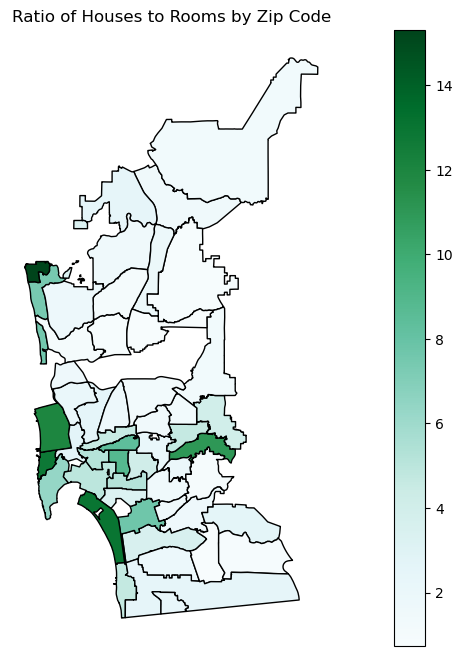

In [63]:
# Plot our map
house_room_gdf.plot(column="ratio", cmap = 'BuGn', edgecolor = 'k', legend = True, figsize=(16,8))
plt.title("Ratio of Houses to Rooms by Zip Code")
plt.axis('off');

In the above map, a darker shaded area indicates a higher proportion of house-type properties over room-type properties, whereas ligher shaded areas indiciate the opposite.

In [ ]:
# Export the final df for the next notebook
eda_income_df.to_csv("../Data/eda.csv.gz", compression = "gzip", index= False)